In [1]:
import pickle 
import numpy as np 
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import community
import collections
import seaborn.objects as so
from scipy.stats import chi2_contingency

from src.utils.data_utils import *
from src.utils.general_utils import *
from src.utils.mapping import *
from src.utils.langue import *

In [2]:
movie_path = 'data/Movie.pkl'
actors_path = 'data/Actor.pkl'

with open(movie_path, 'rb') as file:
    Movie = pickle.load(file)
Movie = Movie.reset_index()
with open(actors_path, 'rb') as file:
    Actor = pickle.load(file)

C:\Users\Thibault Schiesser\AppData\Local\Temp\ipykernel_24520\2668311966.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  Movie = pickle.load(file)


# Network with language

## Actor Network and indentifying the language of the film

In [3]:
start_time = time.time()
G = custom_create_actor_network(Actor, Movie, min_movies=60, min_releasedate=3000)
print("Created graph with actors:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
end_time = time.time()
print(f"time to compute: {end_time - start_time:.1f} seconds")
partition = community.best_partition(G)
values = [partition.get(node) for node in G.nodes()]
counter=collections.Counter(values)

Creating network: 100%|██████████| 21733/21733 [00:53<00:00, 405.95it/s] 


Created graph with actors:
Number of nodes: 422
Number of edges: 9471
time to compute: 54.1 seconds


In [4]:
langue_color_mapping = {
    'English Language': "#cfe2f3",  # Light blue
    'French Language': "#f8d7da",   # Light pink
    'Hindi Language': "#d4edda",    # Light green
    'Spanish Language': "#fff3cd",  # Light yellow
    'Italian Language': "#e2c2f7",  # Light purple
    'German Language': "#d1ecf1",   # Light cyan
    'Silent film': "#f9c9a0",       # Light peach
    'Japanese Language': "#f1e8e2", # Light beige
}
default_color = (0, 0, 0, 0)
edge_colors = [langue_color_mapping.get(G[u][v]["langue"], default_color) for u, v in G.edges]

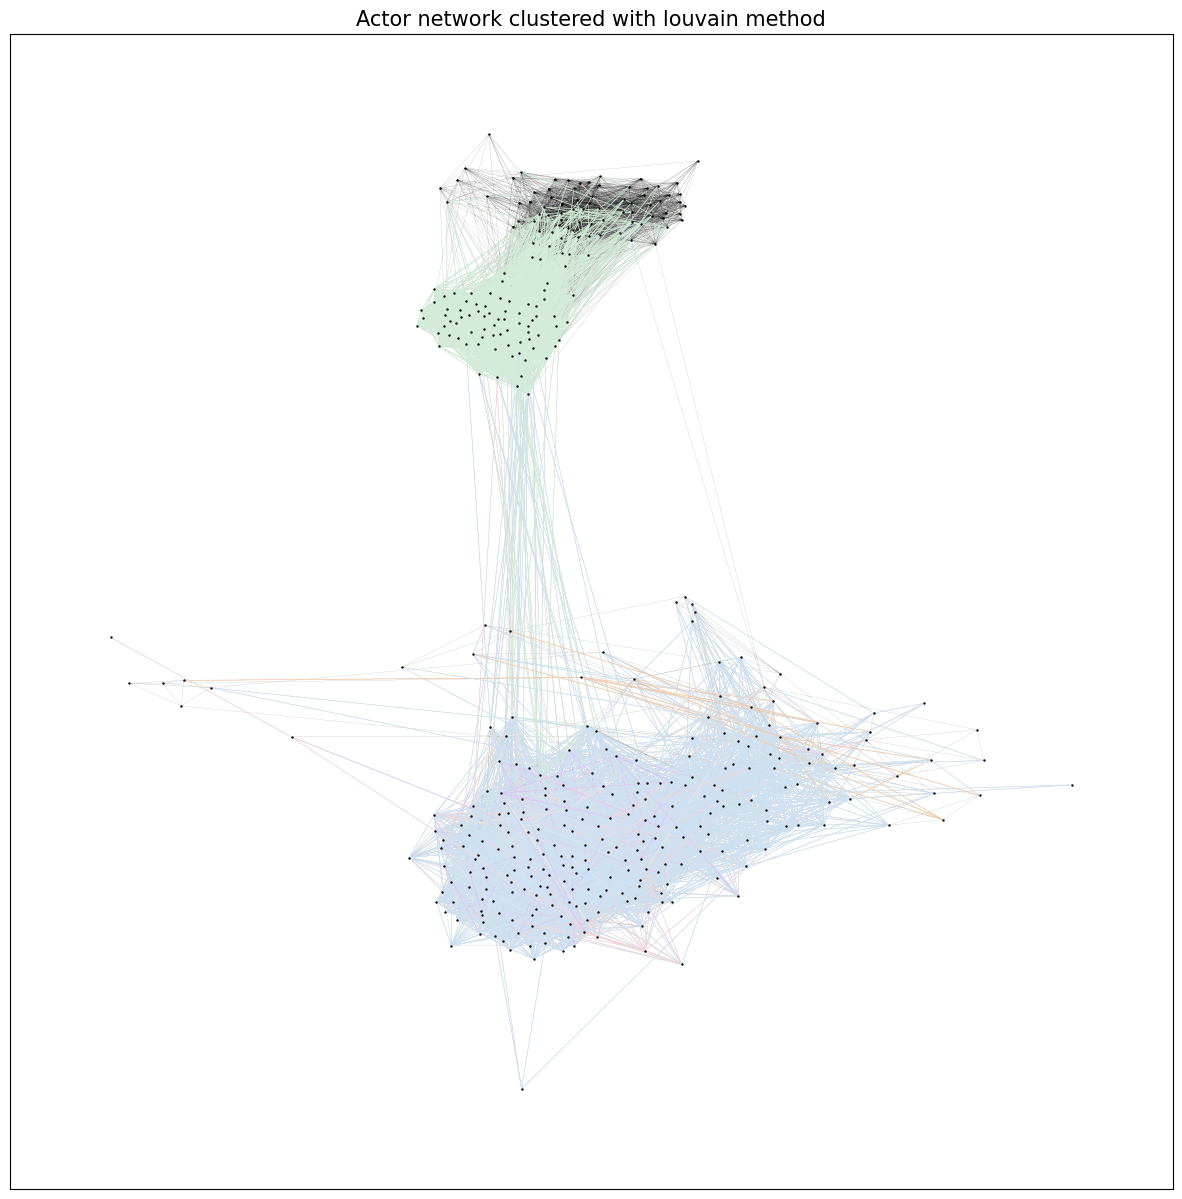

time to compute: 1.3 seconds


In [5]:
start_time = time.time()
sp = nx.spring_layout(G, k=0.2, seed=42)
plt.figure(figsize=(15, 15))
nx.draw_networkx(G, pos=sp, with_labels=False, node_size=0.5, node_color="k", width=0.05)
nx.draw_networkx_edges(G, pos=sp, width=0.5, edge_color=edge_colors, style='solid')
# plt.axes('off')
plt.title("Actor network clustered with louvain method", fontsize=15)
plt.show()
end_time = time.time()
print(f"time to compute: {end_time - start_time:.1f} seconds")

## Movie language

Do the actors playing in a language play in movie in other language ?

In [6]:
actor_language = create_actor_language_dataset(Movie, Actor, 5)

We lose 11.47% of the dataset of movies with this operation.


In [7]:
actor_count_per_language = create_cross_language(actor_language)

C:\Users\Thibault Schiesser\OneDrive\Bureau\MA3\CS-401 - Applied data analysis\ada-2024-project-importnumpyaspd\src\utils\langue.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y='sum', data=data, palette='viridis', log=False)


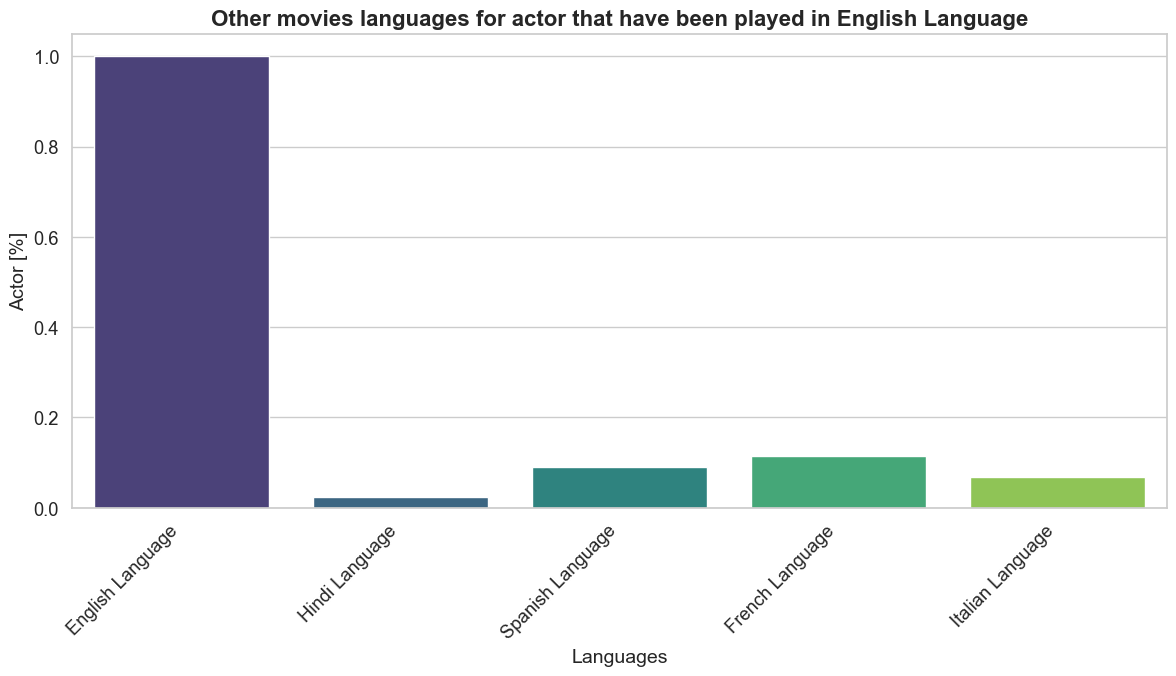

C:\Users\Thibault Schiesser\OneDrive\Bureau\MA3\CS-401 - Applied data analysis\ada-2024-project-importnumpyaspd\src\utils\langue.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y='sum', data=data, palette='viridis', log=False)


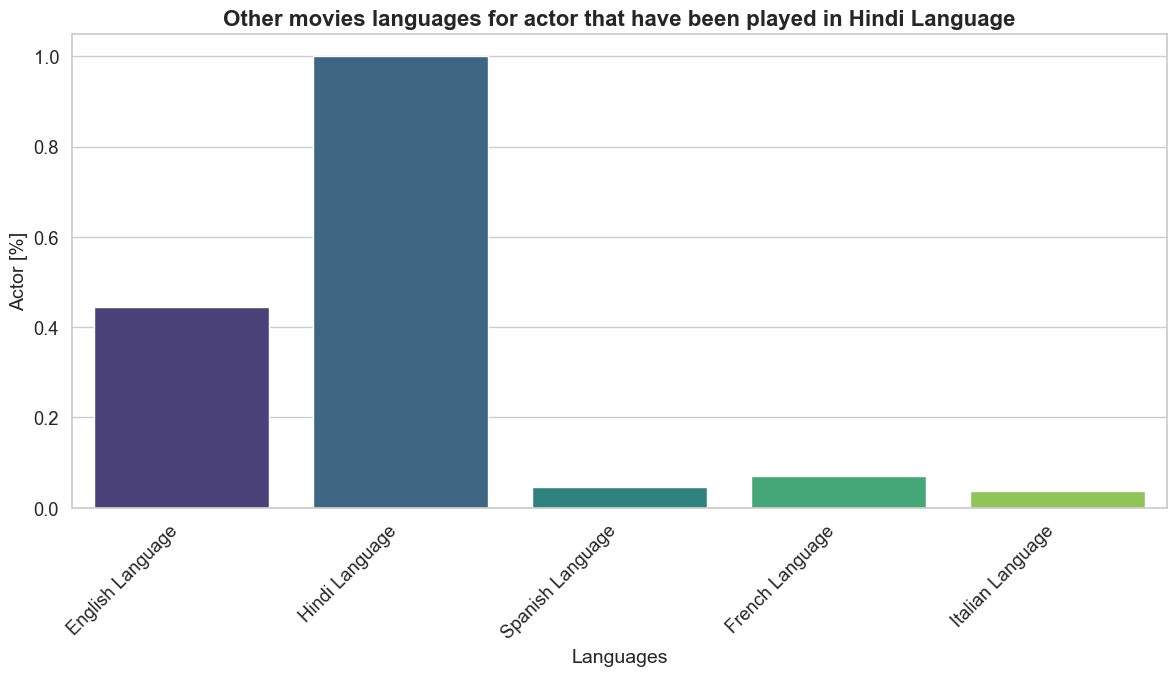

C:\Users\Thibault Schiesser\OneDrive\Bureau\MA3\CS-401 - Applied data analysis\ada-2024-project-importnumpyaspd\src\utils\langue.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y='sum', data=data, palette='viridis', log=False)


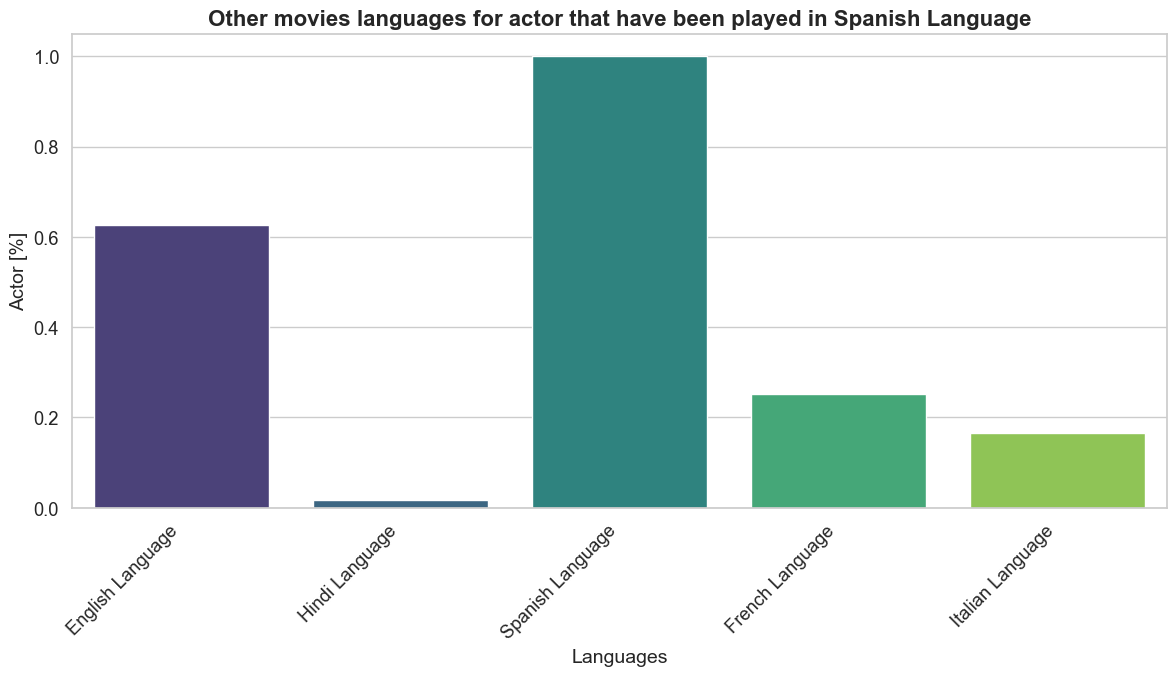

C:\Users\Thibault Schiesser\OneDrive\Bureau\MA3\CS-401 - Applied data analysis\ada-2024-project-importnumpyaspd\src\utils\langue.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y='sum', data=data, palette='viridis', log=False)


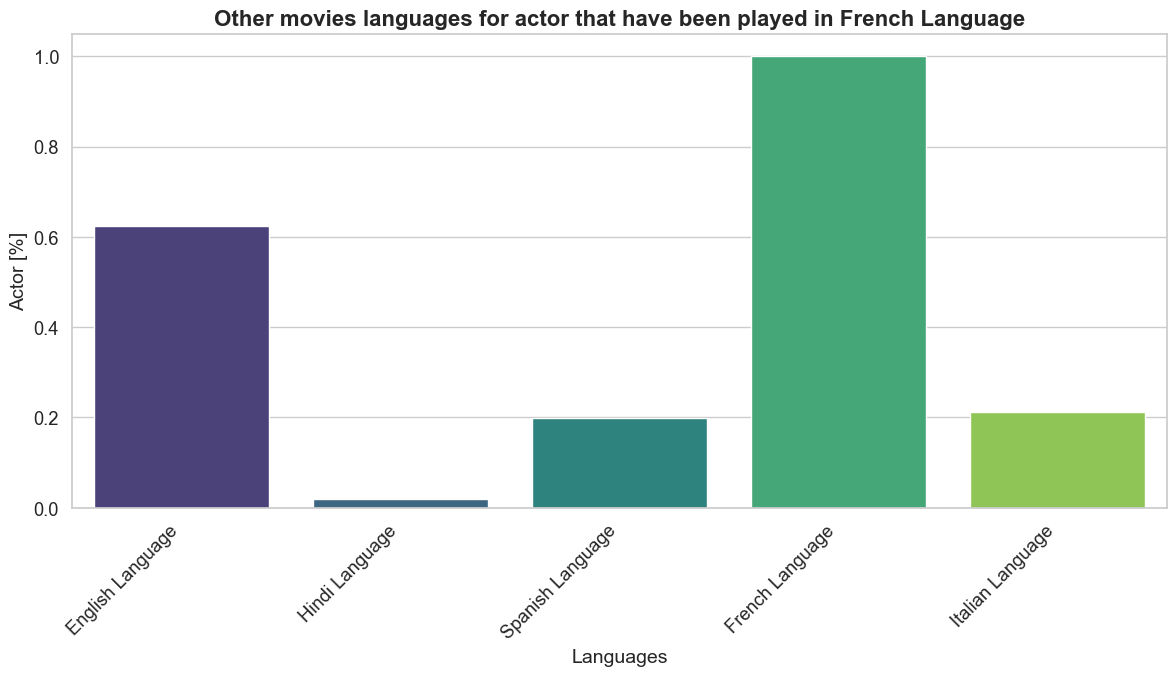

C:\Users\Thibault Schiesser\OneDrive\Bureau\MA3\CS-401 - Applied data analysis\ada-2024-project-importnumpyaspd\src\utils\langue.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y='sum', data=data, palette='viridis', log=False)


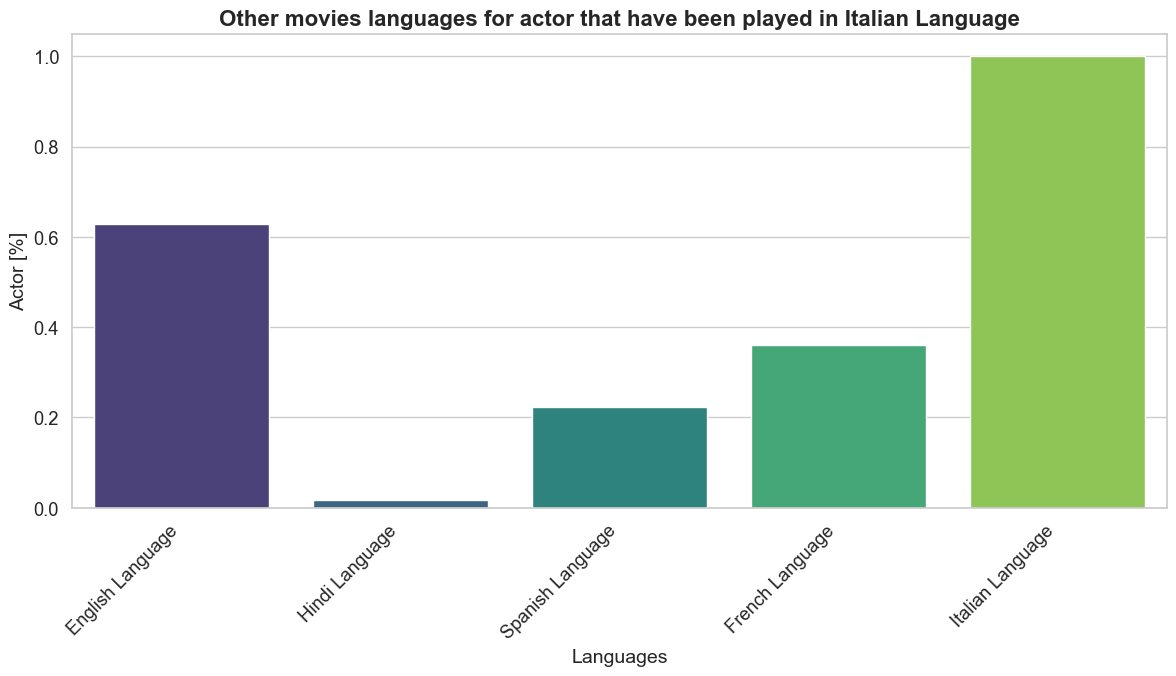

In [8]:
plot_language_histograms(actor_count_per_language)

**Petit bonus : Actor qui ont joués dans énomement de langue différente :**

change selon explode ou pas .... A voir

In [9]:
actor_language2 = create_actor_language_dataset(Movie, Actor, 10)

We lose 11.47% of the dataset of movies with this operation.


In [10]:
one_zero = (actor_language2 > 0).astype(int)

In [11]:
one_zero["sum"] = one_zero.sum(axis=1)

In [12]:
one_zero[one_zero["sum"]>8]

Movie_languages,English Language,Hindi Language,Spanish Language,French Language,Italian Language,German Language,Silent film,Japanese Language,Tamil Language,Malayalam Language,sum
/m/012d40,1,1,1,1,1,1,0,1,1,1,9


Jacky Chan sans explode, autrement 4 personnes (moins connus) qui ont joué en 4 ou 5 langues

## Relation nombre de film - expatriation

In [13]:
movie_count_per_language = create_cross_language_count(actor_language)

Pour les actor ayant joué en anglais, regardons si nous avons la même distribution de langue selon le nombre de film. Voici 4 groupes d'acteur différents :

- **group 1** : $1 \leq \text{nb\_movie} \leq 5$
- **group 2** : $6 \leq \text{nb\_movie} \leq 10$
- **group 3** : $11 \leq \text{nb\_movie} \leq 25$
- **group 4** : $26 \leq \text{nb\_movie}$

In [14]:
# select all actors that have been played in english
movie_count_english=movie_count_per_language['English Language']

In [15]:
# create a dict that has a key per group and movie count per language per actor
dict_group = create_group(movie_count_english)

Size of groups : (65917, 5366, 4187, 1787)


In [16]:
# create a dict that has a key per group and the movie count for each language
distribution_dict = create_distribution_for_each_group(dict_group, number_group = 4)

**Test the distribution of the 4 groups using Chi2 :** <br> 
h0 : la proportion des langues est la même dans chaque groupe

In [17]:
matrix = pd.DataFrame(distribution_dict, index=[1,2,3,4]).T
chi2, p_value, dof, expected = chi2_contingency(matrix)
print_result_chi2(chi2, p_value, dof, expected)

Statistique du Chi-2 : 14590.076681211565
P-value : 0.0
Degrés de liberté : 12


Tableau attendu théorique :
 [[88495.05141468 33238.1324486  54887.86153413 62168.95460259]
 [ 5948.46547283  2234.20270502  3689.45544405  4178.8763781 ]
 [ 3907.95392256  1467.80060585  2423.85568859  2745.38978301]
 [ 6035.18536073  2266.77409827  3743.24228436  4239.79825664]
 [ 3517.34382921  1321.09014226  2181.58504887  2470.98097966]]


Les distributions sont statistiquement différentes (p < 0.05).


In [18]:
nb_group = 4
list_languages = get_most_represented_language(Movie, 5)

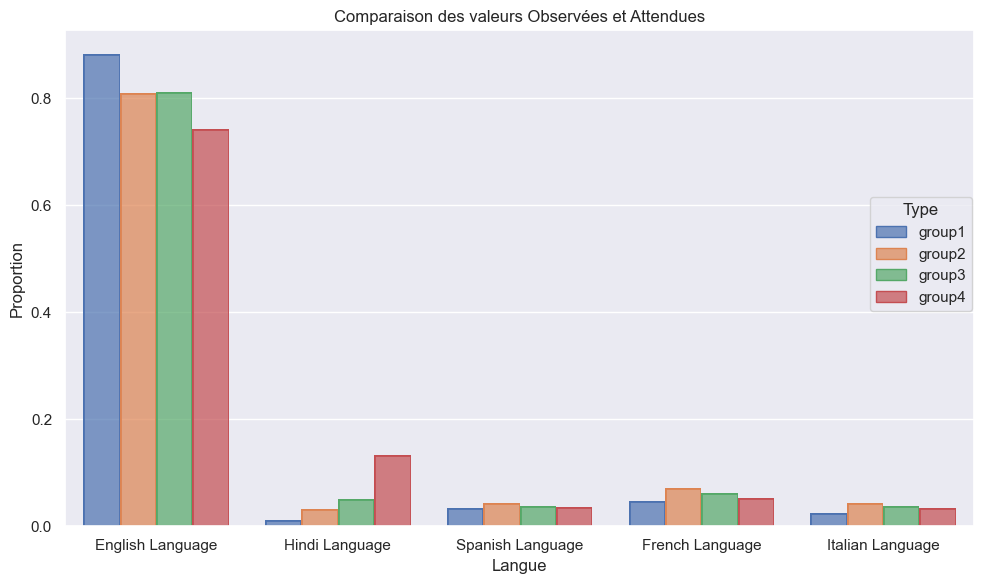

In [19]:
plot_group_distribution_language(matrix, nb_group, list_languages)